# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [4]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в этой функции.
Вычислите градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)


In [5]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def sqr(x):
    return x*x, 2*x

check_gradient(sqr, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [8]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [9]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [11]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [14]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
batch_size = 1
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
batch_size = 3
predictions = np.zeros((batch_size, 3))
target_index = np.ones(batch_size, np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

Gradient check passed!
Gradient check passed!


True

### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [15]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [16]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [17]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 2.302670
Epoch 1, loss: 2.301726
Epoch 2, loss: 2.301804
Epoch 3, loss: 2.301140
Epoch 4, loss: 2.301279
Epoch 5, loss: 2.301309
Epoch 6, loss: 2.301521
Epoch 7, loss: 2.300650
Epoch 8, loss: 2.301273
Epoch 9, loss: 2.301426


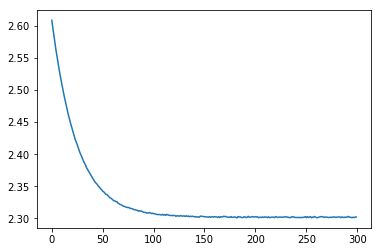

In [18]:
# let's look at the loss history!
plt.plot(loss_history)

In [19]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.141
Epoch 0, loss: 2.300718
Epoch 1, loss: 2.301493
Epoch 2, loss: 2.301770
Epoch 3, loss: 2.300723
Epoch 4, loss: 2.302111
Epoch 5, loss: 2.301006
Epoch 6, loss: 2.300889
Epoch 7, loss: 2.301128
Epoch 8, loss: 2.301478
Epoch 9, loss: 2.301193
Epoch 10, loss: 2.300586
Epoch 11, loss: 2.301209
Epoch 12, loss: 2.300733
Epoch 13, loss: 2.301090
Epoch 14, loss: 2.300837
Epoch 15, loss: 2.300624
Epoch 16, loss: 2.301859
Epoch 17, loss: 2.300271
Epoch 18, loss: 2.301125
Epoch 19, loss: 2.301072
Epoch 20, loss: 2.301339
Epoch 21, loss: 2.300721
Epoch 22, loss: 2.302173
Epoch 23, loss: 2.301391
Epoch 24, loss: 2.302210
Epoch 25, loss: 2.300682
Epoch 26, loss: 2.300522
Epoch 27, loss: 2.300583
Epoch 28, loss: 2.300680
Epoch 29, loss: 2.301149
Epoch 30, loss: 2.301337
Epoch 31, loss: 2.301591
Epoch 32, loss: 2.302400
Epoch 33, loss: 2.301269
Epoch 34, loss: 2.301376
Epoch 35, loss: 2.300754
Epoch 36, loss: 2.301556
Epoch 37, loss: 2.301705
Epoch 38, loss: 2.301396
Epoch 39, loss: 2.

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [20]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = None

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        classifier.fit(train_X, train_y, epochs=num_epochs, learning_rate=learning_rate, batch_size=batch_size, 
                       reg=reg_strength)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if not best_val_accuracy or accuracy > best_val_accuracy:
            best_classifier = classifier
            best_val_accuracy = accuracy

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 2.301833
Epoch 1, loss: 2.298755
Epoch 2, loss: 2.297273
Epoch 3, loss: 2.298163
Epoch 4, loss: 2.294502
Epoch 5, loss: 2.294890
Epoch 6, loss: 2.296107
Epoch 7, loss: 2.295313
Epoch 8, loss: 2.293814
Epoch 9, loss: 2.297480
Epoch 10, loss: 2.294238
Epoch 11, loss: 2.287536
Epoch 12, loss: 2.288689
Epoch 13, loss: 2.290515
Epoch 14, loss: 2.288825
Epoch 15, loss: 2.290980
Epoch 16, loss: 2.282115
Epoch 17, loss: 2.281176
Epoch 18, loss: 2.287491
Epoch 19, loss: 2.279077
Epoch 20, loss: 2.287191
Epoch 21, loss: 2.277916
Epoch 22, loss: 2.281797
Epoch 23, loss: 2.279000
Epoch 24, loss: 2.282870
Epoch 25, loss: 2.287451
Epoch 26, loss: 2.280613
Epoch 27, loss: 2.284836
Epoch 28, loss: 2.285844
Epoch 29, loss: 2.274874
Epoch 30, loss: 2.274541
Epoch 31, loss: 2.282570
Epoch 32, loss: 2.279747
Epoch 33, loss: 2.277018
Epoch 34, loss: 2.268376
Epoch 35, loss: 2.275841
Epoch 36, loss: 2.274043
Epoch 37, loss: 2.271549
Epoch 38, loss: 2.278803
Epoch 39, loss: 2.274192
Epoch 40, 

Epoch 124, loss: 2.151419
Epoch 125, loss: 2.171687
Epoch 126, loss: 2.169758
Epoch 127, loss: 2.186748
Epoch 128, loss: 2.193682
Epoch 129, loss: 2.224012
Epoch 130, loss: 2.189171
Epoch 131, loss: 2.193778
Epoch 132, loss: 2.198006
Epoch 133, loss: 2.218892
Epoch 134, loss: 2.198873
Epoch 135, loss: 2.191019
Epoch 136, loss: 2.162610
Epoch 137, loss: 2.151568
Epoch 138, loss: 2.156344
Epoch 139, loss: 2.183798
Epoch 140, loss: 2.173975
Epoch 141, loss: 2.208067
Epoch 142, loss: 2.162625
Epoch 143, loss: 2.145364
Epoch 144, loss: 2.194197
Epoch 145, loss: 2.189385
Epoch 146, loss: 2.166449
Epoch 147, loss: 2.161803
Epoch 148, loss: 2.205971
Epoch 149, loss: 2.204741
Epoch 150, loss: 2.157248
Epoch 151, loss: 2.176094
Epoch 152, loss: 2.185587
Epoch 153, loss: 2.202637
Epoch 154, loss: 2.176990
Epoch 155, loss: 2.183933
Epoch 156, loss: 2.173412
Epoch 157, loss: 2.184449
Epoch 158, loss: 2.180863
Epoch 159, loss: 2.168021
Epoch 160, loss: 2.129034
Epoch 161, loss: 2.152094
Epoch 162, l

Epoch 46, loss: 2.133310
Epoch 47, loss: 2.140114
Epoch 48, loss: 2.136419
Epoch 49, loss: 2.185748
Epoch 50, loss: 2.150443
Epoch 51, loss: 2.187084
Epoch 52, loss: 2.157163
Epoch 53, loss: 2.153455
Epoch 54, loss: 2.150877
Epoch 55, loss: 2.145389
Epoch 56, loss: 2.169561
Epoch 57, loss: 2.163746
Epoch 58, loss: 2.182159
Epoch 59, loss: 2.140069
Epoch 60, loss: 2.131772
Epoch 61, loss: 2.172682
Epoch 62, loss: 2.137991
Epoch 63, loss: 2.128714
Epoch 64, loss: 2.148217
Epoch 65, loss: 2.101520
Epoch 66, loss: 2.161803
Epoch 67, loss: 2.142995
Epoch 68, loss: 2.161792
Epoch 69, loss: 2.098003
Epoch 70, loss: 2.182218
Epoch 71, loss: 2.136020
Epoch 72, loss: 2.160547
Epoch 73, loss: 2.198609
Epoch 74, loss: 2.145304
Epoch 75, loss: 2.155882
Epoch 76, loss: 2.141634
Epoch 77, loss: 2.171831
Epoch 78, loss: 2.179736
Epoch 79, loss: 2.176176
Epoch 80, loss: 2.169654
Epoch 81, loss: 2.205113
Epoch 82, loss: 2.167694
Epoch 83, loss: 2.189483
Epoch 84, loss: 2.162695
Epoch 85, loss: 2.139082


Epoch 168, loss: 2.157769
Epoch 169, loss: 2.129862
Epoch 170, loss: 2.150231
Epoch 171, loss: 2.192977
Epoch 172, loss: 2.137508
Epoch 173, loss: 2.167564
Epoch 174, loss: 2.151120
Epoch 175, loss: 2.135154
Epoch 176, loss: 2.152644
Epoch 177, loss: 2.235027
Epoch 178, loss: 2.181772
Epoch 179, loss: 2.153372
Epoch 180, loss: 2.142916
Epoch 181, loss: 2.143809
Epoch 182, loss: 2.169618
Epoch 183, loss: 2.146699
Epoch 184, loss: 2.159130
Epoch 185, loss: 2.177072
Epoch 186, loss: 2.168138
Epoch 187, loss: 2.124210
Epoch 188, loss: 2.205120
Epoch 189, loss: 2.115634
Epoch 190, loss: 2.150837
Epoch 191, loss: 2.135990
Epoch 192, loss: 2.173070
Epoch 193, loss: 2.214944
Epoch 194, loss: 2.186804
Epoch 195, loss: 2.140861
Epoch 196, loss: 2.138879
Epoch 197, loss: 2.179373
Epoch 198, loss: 2.156477
Epoch 199, loss: 2.160647
Epoch 0, loss: 2.149718
Epoch 1, loss: 2.193658
Epoch 2, loss: 2.145269
Epoch 3, loss: 2.120277
Epoch 4, loss: 2.132013
Epoch 5, loss: 2.189548
Epoch 6, loss: 2.163570


Epoch 92, loss: 2.143080
Epoch 93, loss: 2.121469
Epoch 94, loss: 2.160899
Epoch 95, loss: 2.133570
Epoch 96, loss: 2.197222
Epoch 97, loss: 2.130029
Epoch 98, loss: 2.150406
Epoch 99, loss: 2.161177
Epoch 100, loss: 2.207153
Epoch 101, loss: 2.157422
Epoch 102, loss: 2.155380
Epoch 103, loss: 2.138817
Epoch 104, loss: 2.119430
Epoch 105, loss: 2.173211
Epoch 106, loss: 2.158731
Epoch 107, loss: 2.179999
Epoch 108, loss: 2.160601
Epoch 109, loss: 2.163665
Epoch 110, loss: 2.159429
Epoch 111, loss: 2.206752
Epoch 112, loss: 2.128542
Epoch 113, loss: 2.123387
Epoch 114, loss: 2.084403
Epoch 115, loss: 2.152660
Epoch 116, loss: 2.143100
Epoch 117, loss: 2.138577
Epoch 118, loss: 2.145552
Epoch 119, loss: 2.140648
Epoch 120, loss: 2.142378
Epoch 121, loss: 2.138828
Epoch 122, loss: 2.135891
Epoch 123, loss: 2.178520
Epoch 124, loss: 2.166615
Epoch 125, loss: 2.146877
Epoch 126, loss: 2.180962
Epoch 127, loss: 2.180950
Epoch 128, loss: 2.138459
Epoch 129, loss: 2.160224
Epoch 130, loss: 2.1

Epoch 13, loss: 2.178906
Epoch 14, loss: 2.159346
Epoch 15, loss: 2.113855
Epoch 16, loss: 2.136755
Epoch 17, loss: 2.131089
Epoch 18, loss: 2.139772
Epoch 19, loss: 2.202631
Epoch 20, loss: 2.183731
Epoch 21, loss: 2.147043
Epoch 22, loss: 2.140656
Epoch 23, loss: 2.138532
Epoch 24, loss: 2.170641
Epoch 25, loss: 2.145534
Epoch 26, loss: 2.151104
Epoch 27, loss: 2.131888
Epoch 28, loss: 2.125103
Epoch 29, loss: 2.141492
Epoch 30, loss: 2.124242
Epoch 31, loss: 2.155239
Epoch 32, loss: 2.142096
Epoch 33, loss: 2.149011
Epoch 34, loss: 2.152342
Epoch 35, loss: 2.170698
Epoch 36, loss: 2.128710
Epoch 37, loss: 2.175731
Epoch 38, loss: 2.189938
Epoch 39, loss: 2.126117
Epoch 40, loss: 2.127685
Epoch 41, loss: 2.176054
Epoch 42, loss: 2.189403
Epoch 43, loss: 2.170134
Epoch 44, loss: 2.162650
Epoch 45, loss: 2.144150
Epoch 46, loss: 2.159053
Epoch 47, loss: 2.143523
Epoch 48, loss: 2.139932
Epoch 49, loss: 2.141843
Epoch 50, loss: 2.186548
Epoch 51, loss: 2.166915
Epoch 52, loss: 2.119894


# Какой же точности мы добились на тестовых данных?

In [21]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.221000
